In [4]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import os
import talos as ta
from talos.model.early_stopper import early_stopper
from sklearn.preprocessing import StandardScaler

%load_ext tensorboard
import tensorflow_addons as tfa
import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.metrics import Recall, Precision
import seaborn as sns

from sklearn.model_selection import train_test_split


import tensorflow as tf

from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [96]:
p = {
    'first_neuron':55,  #Done
     'hidden_neuron':50, #Done

     'hidden_layers':3,   #Done

     
    'epochs': 100000, # never touch it


    'last_activation': 'sigmoid', #never touch it


    'batch_size':64, #Done

    'lr':0.001,
    
    'kernel_regularizer_l1':0.000001,#Done
    'kernel_regularizer_l2':0.00001,#Done
    'bias_regularizer':0.0001,#Done
    'activity_regularizer':0.0001,#Done

    'dropout': 0.3,
    
  
    'kernel_initializer': 'uniform',#Done

    'activation_layer':'tanh',#Done
 
    'batc_normalization':True#Done
 
}

In [127]:

def numerai_model(x_train, y_train, x_val, y_val, params):
    
    print(params)

    model = Sequential()
    
    ## initial layer
    model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
                    activation='relu',
               
                    kernel_initializer = params['kernel_initializer'],
                    kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    if params['batc_normalization']==True:
        model.add(BatchNormalization())
        
    if params['dropout']!=0:
        model.add(Dropout(params['dropout']))
    
    ## hidden layers
    for i in range(params['hidden_layers']):
        print (f"adding layer {i+1}")
        model.add(Dense(params['hidden_neuron'], activation='relu',
                    kernel_initializer=params['kernel_initializer'],
                        kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                    l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                       ))
        if params['batc_normalization']==True:
            model.add(BatchNormalization())
            
        if params['dropout']!=0:
            model.add(Dropout(params['dropout']))
    
    
    ## final layer
    model.add(Dense(3, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer'],
                   kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                               l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adagrad(learning_rate=params['lr']),
                  metrics=[tfa.metrics.FBetaScore(num_classes=3,beta=1.0)])
    
  
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0,
                        class_weight={0 : 0.64147775,
                                      1 : 2.42539683,
                                      2 : 0.97201018},
                        callbacks = [
                                     EarlyStopping(monitor='val_loss',
                                        min_delta=0.01,
                                        patience=50, mode='min',verbose=1,
                                                      restore_best_weights=True)
                                    ] #,ta.live(),
                        )

    return history, model

In [135]:

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []
dane_do_zapisu=pd.DataFrame()
licznik=1

for train, test in kfold.split(caly_df,train_label_2): # train 80, test 20 %
    train, val = train_test_split(train, test_size=0.1, random_state=42) # train 80 % test 10% val 10 %
    
    returny=numerai_model(caly_df[train], caly_label[train], caly_df[val],caly_label[val], p)
    
    model=returny[1]
    # evaluate the model

    
    predictions = model.predict(caly_df[test])
    rezults=[]
    w_0=[]
    w_1=[]
    w_2=[]
    for z in predictions:
        rezults.append(np.argmax(z))
        w_0.append(z[0])
        w_1.append(z[1])
        w_2.append(z[2])
    


    scores=f1_score(train_label_2[test], rezults,average='macro')
    
    dane_folda=pd.DataFrame({"pred": list(rezults),
                                "obs": train_label_2[test].tolist(),
                                 "probability_0":list(w_0),
                                 "probability_1":list(w_1),
                                 "probability_2":list(w_2),
                                "Fold":licznik})
    
    dane_do_zapisu=pd.concat([dane_do_zapisu,dane_folda])
    cvscores.append(scores)
    licznik+=1
    
     

{'first_neuron': 55, 'hidden_neuron': 50, 'hidden_layers': 3, 'epochs': 100000, 'last_activation': 'sigmoid', 'batch_size': 64, 'lr': 0.001, 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'bias_regularizer': 0.0001, 'activity_regularizer': 0.0001, 'dropout': 0.08, 'kernel_initializer': 'uniform', 'activation_layer': 'tanh', 'batc_normalization': True}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Restoring model weights from the end of the best epoch: 1.
Epoch 00051: early stopping
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [136]:
cvscores

[0.4679096045197739,
 0.4600454112649235,
 0.5459252649794505,
 0.45139542996685855,
 0.17120622568093383]

In [137]:
sum(cvscores)/len(cvscores) #0.032977654217233775

0.41929638728238805

In [138]:
cf_matrix = confusion_matrix(dane_do_zapisu['obs'], dane_do_zapisu['pred'])

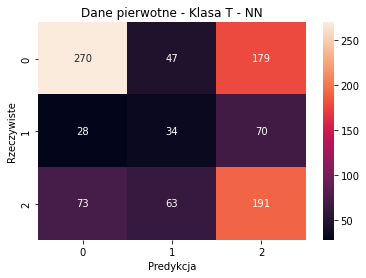

In [139]:

ax = plt.axes()
sns.heatmap(cf_matrix, annot=True, fmt='g')

ax.set_title('Dane pierwotne - Klasa T - NN')
plt.ylabel('Rzeczywiste')
plt.xlabel('Predykcja')
plt.show()


In [ ]:
precision = precision_score(dane_do_zapisu['obs'], dane_do_zapisu['pred'],  average='macro')
recall = recall_score(dane_do_zapisu['obs'], dane_do_zapisu['pred'],  average='macro')
f1score=f1_score(dane_do_zapisu['obs'], dane_do_zapisu['pred'], average='macro')
print('Recall: %.3f' % recall)
print('Precision: %.3f' % precision)
print('F1score: %.3f' % f1score)

In [ ]:
## Wczytywanie danych 

In [128]:
train_df=pd.read_csv("D:/STUDIA/ROK_II/Magisterka/Modele/Dane pierwotne/Dane_do_uczenia_T.csv", encoding="utf-8")
del train_df['Unnamed: 0']
train_df['scale'].loc[(train_df['scale'] == 'T1')] = 0
train_df['scale'].loc[(train_df['scale'] == 'T2')] = 1
train_df['scale'].loc[(train_df['scale'] == 'T3')] = 2
train_label=train_df['scale']
del train_df['scale']
scaler = StandardScaler()
train_df=scaler.fit_transform(train_df)
train_label=np.asarray(train_label).astype(np.int)
train_label_2=train_label
encoder = LabelEncoder()
encoder.fit(train_label)
train_label = encoder.transform(train_label)
# convert integers to dummy variables (i.e. one hot encoded)

train_label = np_utils.to_categorical(train_label)

In [129]:
train_df

array([[-0.15545413, -0.19268726, -0.18007555, ..., -0.11325408,
        -0.1310684 , -0.14934876],
       [-0.1740803 , -0.20813705, -0.23130506, ..., -0.20152997,
        -0.17992108, -0.14934876],
       [-0.19408164, -0.21062068, -0.23130506, ..., -0.20152997,
        -0.17992108, -0.14934876],
       ...,
       [-0.21070965, -0.21834049, -0.23130506, ..., -0.20152997,
        -0.17992108, -0.14934876],
       [ 0.00099515, -0.02176597, -0.23130506, ..., -0.20152997,
        -0.17992108, -0.14934876],
       [ 0.03374514, -0.21834049, -0.23130506, ..., -0.20152997,
        -0.08266341, -0.14934876]])

In [130]:
train_df.shape

(955, 105)

In [131]:
caly_df=train_df

In [132]:
caly_label=train_label

In [133]:
caly_label

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [134]:
train_label_2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [105]:

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []
dane_do_zapisu=pd.DataFrame()
licznik=1

for train, test in kfold.split(caly_df,train_label_2): # train 80, test 20 %
    train, val = train_test_split(train, test_size=0.1, random_state=42) # train 80 % test 10% val 10 %
    
    returny=numerai_model(caly_df[train], caly_label[train], caly_df[val],caly_label[val], p)
    
    model=returny[1]
    # evaluate the model

    
    predictions = model.predict(caly_df[test])
    rezults=[]
    w_0=[]
    w_1=[]
    w_2=[]
    for z in predictions:
        rezults.append(np.argmax(z))
        w_0.append(z[0])
        w_1.append(z[1])
        w_2.append(z[2])
    


    scores=f1_score(train_label_2[test], rezults,average='macro')
    
    dane_folda=pd.DataFrame({"pred": list(rezults),
                                "obs": train_label_2[test].tolist(),
                                 "probability_0":list(w_0),
                                 "probability_1":list(w_1),
                                 "probability_2":list(w_2),
                                "Fold":licznik})
    
    dane_do_zapisu=pd.concat([dane_do_zapisu,dane_folda])
    cvscores.append(scores)
    licznik+=1
    
     

{'first_neuron': 55, 'hidden_neuron': 50, 'hidden_layers': 3, 'epochs': 100000, 'last_activation': 'sigmoid', 'batch_size': 64, 'lr': 0.001, 'kernel_regularizer_l1': 1e-06, 'kernel_regularizer_l2': 1e-05, 'bias_regularizer': 0.0001, 'activity_regularizer': 0.0001, 'dropout': 0.3, 'kernel_initializer': 'uniform', 'activation_layer': 'tanh', 'batc_normalization': True}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.a

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Restoring model weights from the end of the best epoch: 38.
Epoch 00088: early stopping
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [141]:
dane_do_zapisu.to_csv('D:\\STUDIA\\ROK_II\\Magisterka\\Modele\\Dane pierwotne\\Dane z cross-walidacji\\Klasa_T_NN.csv')

In [107]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


## dr 0.3

In [108]:
cvscores

[0.4730920393779641,
 0.4403567787349129,
 0.5193394371175799,
 0.4537548931044866,
 0.4958286848050628]

In [109]:
sum(cvscores)/len(cvscores) #0.032977654217233775

0.47647436662800124

In [110]:
cf_matrix = confusion_matrix(dane_do_zapisu['obs'], dane_do_zapisu['pred'])

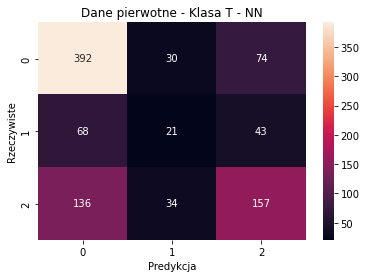

In [111]:

ax = plt.axes()
sns.heatmap(cf_matrix, annot=True, fmt='g')

ax.set_title('Dane pierwotne - Klasa T - NN')
plt.ylabel('Rzeczywiste')
plt.xlabel('Predykcja')
plt.show()


In [112]:
precision = precision_score(dane_do_zapisu['obs'], dane_do_zapisu['pred'],  average='macro')
recall = recall_score(dane_do_zapisu['obs'], dane_do_zapisu['pred'],  average='macro')
f1score=f1_score(dane_do_zapisu['obs'], dane_do_zapisu['pred'], average='macro')
print('Recall: %.3f' % recall)
print('Precision: %.3f' % precision)
print('F1score: %.3f' % f1score)

Recall: 0.477
Precision: 0.493
F1score: 0.478


## dr. 01

In [90]:
cvscores

[0.39946012837547457,
 0.4590458453261094,
 0.5268597934535271,
 0.5028003613369466,
 0.2530650604468367]

In [91]:
sum(cvscores)/len(cvscores) #0.032977654217233775

0.4282462377877789

In [93]:
cf_matrix = confusion_matrix(dane_do_zapisu['obs'], dane_do_zapisu['pred'])

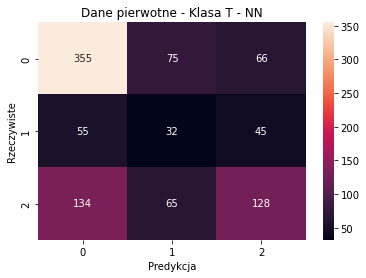

In [94]:

ax = plt.axes()
sns.heatmap(cf_matrix, annot=True, fmt='g')

ax.set_title('Dane pierwotne - Klasa T - NN')
plt.ylabel('Rzeczywiste')
plt.xlabel('Predykcja')
plt.show()


In [95]:
precision = precision_score(dane_do_zapisu['obs'], dane_do_zapisu['pred'],  average='macro')
recall = recall_score(dane_do_zapisu['obs'], dane_do_zapisu['pred'],  average='macro')
f1score=f1_score(dane_do_zapisu['obs'], dane_do_zapisu['pred'], average='macro')
print('Recall: %.3f' % recall)
print('Precision: %.3f' % precision)
print('F1score: %.3f' % f1score)

Recall: 0.450
Precision: 0.458
F1score: 0.449


In [140]:
model.save('D:/STUDIA/ROK_II/Magisterka/Modele/Dane pierwotne/Modele sieci neuro')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the ver

In [ ]:
df = pd.read_csv()